# How to deal with EASE2 DATA FROM F18/SSMIS

In [1]:
from netCDF4 import Dataset
import os 
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
opj = os.path.join
folder="SSMIS-S-91GHzH-Jan21"
filelist=[]
for i in range(31):
    day = str(i+1).zfill(3)
    filename = "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021{}-91H-E-SIR-CSU-v1.5.nc".format(day)
    filelist.append(opj(folder, filename))


Matplotlib created a temporary config/cache directory at /var/folders/5b/69fnmcl56xv87h47bb4l_v8w0000gn/T/matplotlib-69ckzr96 because the default path (/Users/personal/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#De-projection
data_for_proj = Dataset(filelist[0], "r", format="NETCDF4")
X = np.array(data_for_proj["x"])
Y = np.array(data_for_proj["y"])
XX, YY = np.meshgrid(X, Y)
rho2 = XX**2+YY**2
e = 0.0818191908426
a = 6378137
qp = 1. - (1-e**2)*.5*np.log((1-e)/(1+e))/e
beta = -np.arcsin(1 -rho2/(qp*a**2))
lat =  .5*np.pi - (beta + e**2/3.*np.sin(2*beta))
lon = np.arctan2(XX,YY) - np.pi 
pixes = hp.ang2pix(512, lat, lon)

In [3]:
for i, file in enumerate(filelist):
    dataset = Dataset(file,"r", format="NETCDF4")
    tb = np.array(dataset["TB"])
    tbmap = np.zeros(12*512*512)
    tbmap[pixes] = np.array(tb[0])
    tbmap[tbmap==0] = hp.UNSEEN
    mapname = "SSMIS-202101{}-91H-E_South.fits".format(str(i+1).zfill(2))
    hp.write_map(opj(folder, mapname), tbmap, overwrite=True, dtype='float64')

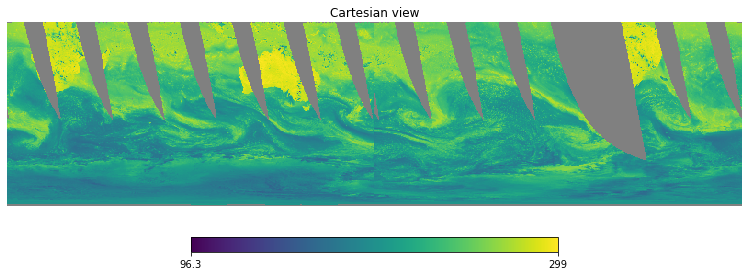

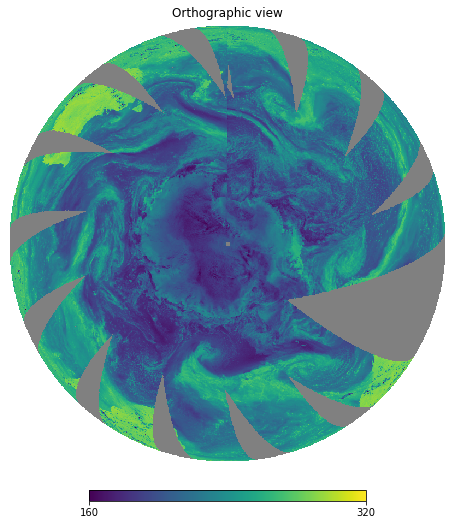

In [4]:
data_for_image = Dataset(filelist[0], "r", format="NETCDF4")
tb = np.array(data_for_image["TB"])
tbmap[pixes] = np.array(tb[0])
tbmap[tbmap==0] = hp.UNSEEN
plt.figure(1, (12,6))
hp.cartview(tbmap, flip="geo", fig=1, latra=[-90,0])
plt.figure(2, (8,8))
hp.orthview(tbmap, rot=[0,-90,0], flip="geo", min=160, max=320, half_sky=True, fig=2)

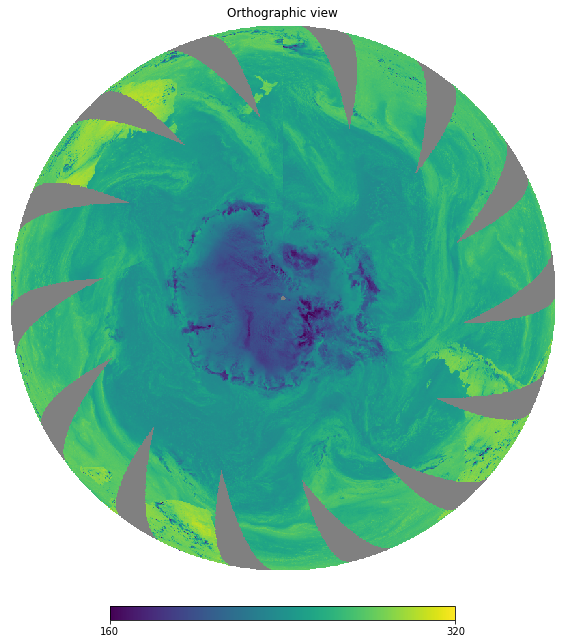

In [5]:
folder="SSMIS-S-91GHzV-Jan21"
filelist=[]
for i in range(31):
    day = str(i+1).zfill(3)
    filename = "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021{}-91V-E-SIR-CSU-v1.5.nc".format(day)
    filelist.append(opj(folder, filename))
for i, file in enumerate(filelist):
    dataset = Dataset(file,"r", format="NETCDF4")
    tb = dataset["TB"]
    tbmap = np.zeros(12*512*512)
    tbmap[pixes] = np.array(tb[0])
    tbmap[tbmap==0] = hp.UNSEEN    
    mapname = "SSMIS-202101{}-91V-E_South.fits".format(str(i+1).zfill(2))
    hp.write_map(opj(folder, mapname), tbmap, dtype='float64', overwrite=True)

plt.figure(1, (10,10))
hp.orthview(tbmap, rot=[0,-90,0], flip="geo", min=160, max=320, half_sky=True, fig=1)

In [6]:
#Temperate Zone
folder="SSMIS-T-91GHzH-Jan21"
filelist=[]
for i in range(31):
    day = str(i+1).zfill(3)
    filename = "NSIDC-0630-EASE2_T3.125km-F18_SSMIS-2021{}-91H-D-SIR-CSU-v1.5.nc".format(day)
    filelist.append(opj(folder, filename))
data_for_proj = Dataset(filelist[0], "r", format="NETCDF4")
X = data_for_proj.variables["x"][:]
Y = data_for_proj.variables["y"][:]
XX, YY = np.meshgrid(X, Y)
e = 0.0818191908426
a = 6378137
k0 = np.sqrt(3/(4-e**2))
qp = 1. - (1-e**2)*.5*np.log((1-e)/(1+e))/e
beta = np.arcsin(2*YY*k0/(a*qp))
colat = np.pi/2. - beta + e**2/3.*np.sin(2*beta)#Up to e2
lon = XX/(a*k0) - np.pi
proj = hp.ang2pix(512, colat, lon)

In [7]:
tbmap = np.zeros(12*512*512)
tb = data_for_proj["TB"]
tbmap[proj] = np.array(tb[0])
tbmap[tbmap==0] = hp.UNSEEN

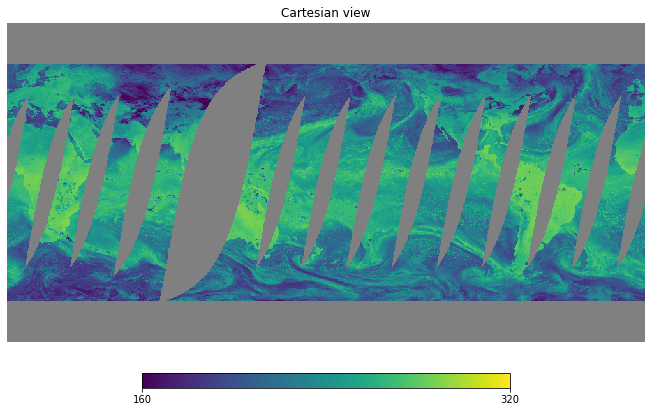

In [8]:
plt.figure(1, (12,6))
hp.cartview(tbmap, xsize=1000, fig=1, flip="geo", min=160, max=320)

In [9]:
#Iterate
for i, file in enumerate(filelist):
    dataset = Dataset(file,"r", format="NETCDF4")
    tb = dataset["TB"]
    tbmap = np.zeros(12*512*512)
    tbmap[proj] = np.array(tb[0])
    tbmap[tbmap==0] = hp.UNSEEN    
    mapname = "SSMIS-202101{}-91H-D_Tempe.fits".format(str(i+1).zfill(2))
    hp.write_map(opj(folder, mapname), tbmap, dtype='float64', overwrite=True)

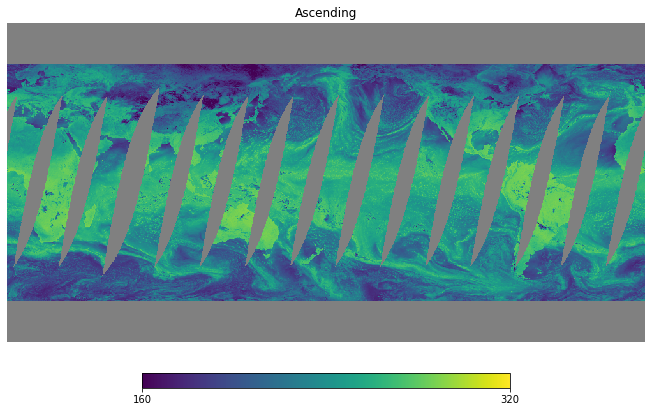

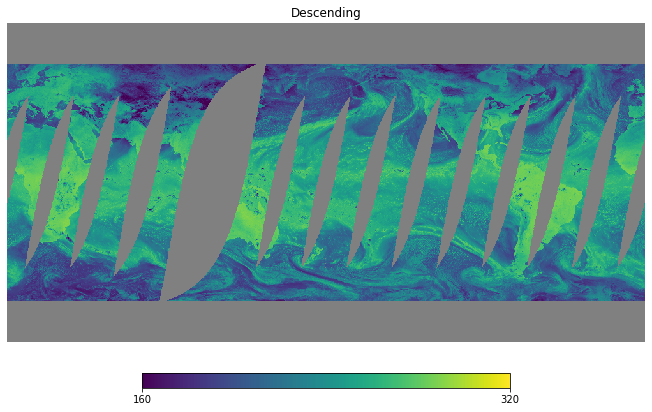

In [10]:
#Combine both daily passes
filepath = opj(folder, "NSIDC-0630-EASE2_T3.125km-F18_SSMIS-2021001-91H-A-SIR-CSU-v1.5.nc")
data_asc = Dataset(filepath, "r", format="NETCDF4")
tba = data_asc["TB"]
tbmapA = np.zeros(12*512*512)
tbmapA[proj] = np.array(tb[0])
tbmapA[tbmapA==0] = hp.UNSEEN
plt.figure(1, (12,6))
hp.cartview(tbmapA, xsize=1000, fig=1, flip="geo", min=160, max=320, title="Ascending")
filepath = opj(folder, "NSIDC-0630-EASE2_T3.125km-F18_SSMIS-2021001-91H-D-SIR-CSU-v1.5.nc")
data_dsc = Dataset(filepath, "r", format="NETCDF4")
tbd = data_dsc["TB"]
tbmapD = np.zeros(12*512*512)
tbmapD[proj] = np.array(tbd[0])
tbmapD[tbmapD==0] = hp.UNSEEN
plt.figure(2, (12,6))
hp.cartview(tbmapD, xsize=1000, fig=2, flip="geo", min=160, max=320, title="Descending")

<Figure size 864x432 with 0 Axes>

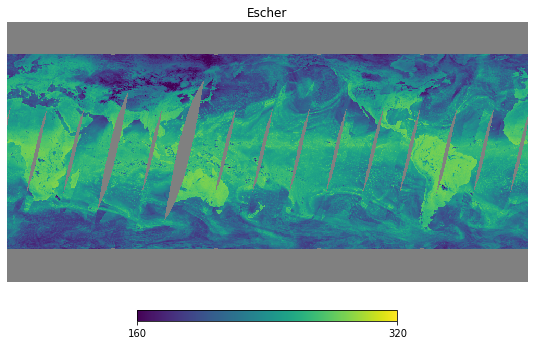

In [11]:
#Combine ascending and descending
asmask = hp.mask_bad(tbmapA)
demask = hp.mask_bad(tbmapD)
asec = .5*(tbmapA+tbmapD)
asec[np.logical_xor(asmask, demask)] = np.maximum(tbmapA, tbmapD)[np.logical_xor(asmask, demask)]
plt.figure(3, (12,6))
hp.cartview(asec, xsize=1000, fig=2, flip="geo", min=160, max=320, title="Escher")

In [12]:
#Do that for everyone
folder="SSMIS-T-91GHzH-Jan21"
for i in range(31):
    day = str(i+1).zfill(3)
    file_dsc = "NSIDC-0630-EASE2_T3.125km-F18_SSMIS-2021{}-91H-D-SIR-CSU-v1.5.nc".format(day)
    file_asc = "NSIDC-0630-EASE2_T3.125km-F18_SSMIS-2021{}-91H-A-SIR-CSU-v1.5.nc".format(day)
    data_dsc = Dataset(opj(folder, file_dsc), "r", format="NETCDF4")
    data_asc = Dataset(opj(folder, file_asc), "r", format="NETCDF4")
    
    tba = data_asc["TB"]
    tbd = data_dsc["TB"]
    
    tbmapA = np.zeros(12*512*512)
    tbmapA[proj] = np.array(tba[0])
    tbmapA[tbmapA==0] = hp.UNSEEN
    
    tbmapD = np.zeros(12*512*512)
    tbmapD[proj] = np.array(tbd[0]) 
    tbmapD[tbmapD==0] = hp.UNSEEN
    
    asmask = hp.mask_bad(tbmapA)
    demask = hp.mask_bad(tbmapD)
    asec = .5*(tbmapA+tbmapD)
    asec[np.logical_xor(asmask, demask)] = np.maximum(tbmapA, tbmapD)[np.logical_xor(asmask, demask)]
    mapname = "SSMIS-202101{}-91H_Tempe.fits".format(str(i+1).zfill(2))
    hp.write_map(opj(folder, mapname), asec, dtype='float64', overwrite=True)
    
    

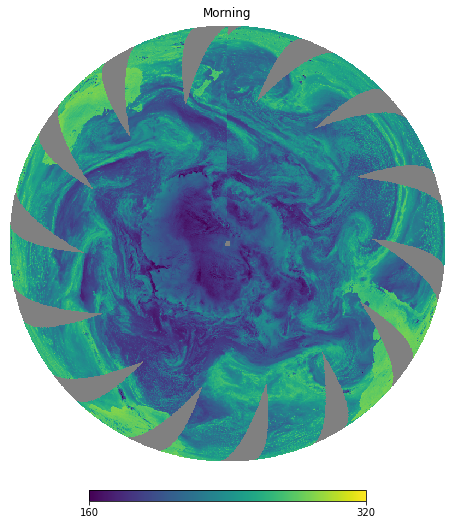

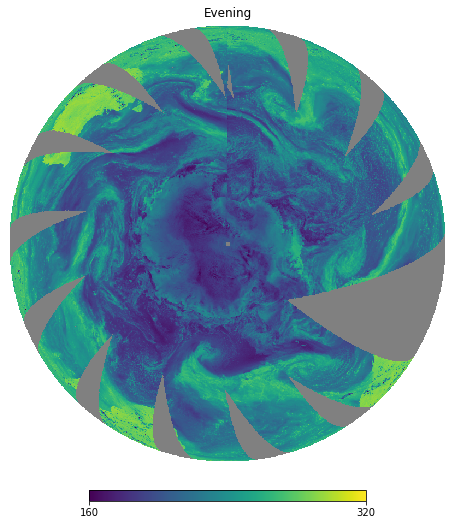

In [18]:
#Daily passes for the ocean:
folder="SSMIS-S-91GHzH-Jan21"
morning = Dataset(opj(folder, "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021001-91H-M-SIR-CSU-v1.5.nc"), 
                  "r", format="NETCDF4")
evening = Dataset(opj(folder, "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021001-91H-E-SIR-CSU-v1.5.nc"), 
                  "r", format="NETCDF4")
morningtemp = np.array(morning["TB"])
morningmap = np.zeros(12*512*512)
morningmap[pixes] = np.array(morningtemp[0])
morningmap[morningmap==0] = hp.UNSEEN
eveningtemp = np.array(evening["TB"])
eveningmap = np.zeros(12*512*512)
eveningmap[pixes] = np.array(eveningtemp[0])
eveningmap[eveningmap==0] = hp.UNSEEN
plt.figure(1, (8,8))
hp.orthview(morningmap, rot=[0,-90,0], flip="geo", min=160, max=320, half_sky=True, fig=1, title="Morning")
plt.figure(2, (8,8))
hp.orthview(eveningmap, rot=[0,-90,0], flip="geo", min=160, max=320, half_sky=True, fig=2, title="Evening")

In [14]:
mormask = hp.mask_bad(morningmap)
evemask = hp.mask_bad(eveningmap)
daymap = .5*(morningmap+eveningmap)
daymap[np.logical_xor(mormask, evemask)] = np.maximum(morningmap, eveningmap)[np.logical_xor(mormask, evemask)]

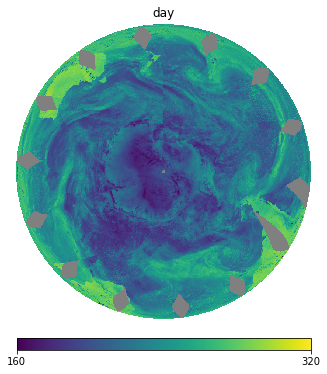

In [17]:
hp.orthview(daymap, rot=[0,-90,0], flip="geo", min=160, max=320, half_sky=True, fig=2, title="day")

In [20]:
#South pole for everyone
folder="SSMIS-S-91GHzH-Jan21"
for i in range(31):
    day = str(i+1).zfill(3)
    file_mor = "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021{}-91H-M-SIR-CSU-v1.5.nc".format(day)
    data_mor = Dataset(opj(folder, file_mor), "r", format="NETCDF4")
    temp_mor = np.array(data_mor["TB"])
    
    map_mor = np.zeros(12*512*512)
    map_mor[pixes] = np.array(temp_mor[0])
    map_mor[map_mor==0] = hp.UNSEEN
    mask_mor = hp.mask_bad(map_mor)
    
    file_eve = "NSIDC-0630-EASE2_S3.125km-F18_SSMIS-2021{}-91H-E-SIR-CSU-v1.5.nc".format(day)
    data_eve = Dataset(opj(folder, file_eve), "r", format="NETCDF4")
    temp_eve = np.array(data_eve["TB"])

    map_eve = np.zeros(12*512*512)
    map_eve[pixes] = np.array(temp_eve[0])
    map_eve[map_eve==0] = hp.UNSEEN
    mask_eve = hp.mask_bad(map_eve)
    
    daymap = .5*(map_mor+map_eve)
    daymap[np.logical_xor(mask_mor, mask_eve)] = np.maximum(map_mor, map_eve)[np.logical_xor(mask_mor, mask_eve)]
    mapname = "SSMIS-202101{}-91H_South.fits".format(str(i+1).zfill(2))
    hp.write_map(opj(folder, mapname), daymap, dtype='float64', overwrite=True)


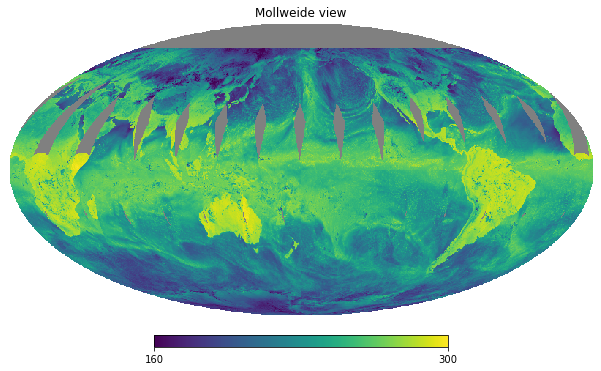

In [16]:
#Combine the temperate and polar maps
polmask = hp.mask_bad(daymap)
tepmask = hp.mask_bad(asec)
fullmap = .5*(daymap+asec)
fullmap[np.logical_xor(polmask, tepmask)] = np.maximum(daymap, asec)[np.logical_xor(polmask, tepmask)]
hp.mollview(fullmap, flip="geo", min=160, max=300)

In [21]:
#Combine south and temperate 
south_folder = "SSMIS-S-91GHzH-Jan21"
tempe_folder = "SSMIS-T-91GHzH-Jan21"
out_folder = "SSMIS-91GHzH-Jan21"
for i in range(31):
    day = str(i+1).zfill(2)
    
    south_file = opj(south_folder, "SSMIS-202101{}-91H_South.fits".format(day))
    south_map = hp.read_map(south_file)
    south_mask = hp.mask_bad(south_map)
    
    tempe_file = opj(tempe_folder, "SSMIS-202101{}-91H_Tempe.fits".format(day))
    tempe_map = hp.read_map(tempe_file)
    tempe_mask = hp.mask_bad(tempe_map)
    
    fullmap = .5*(tempe_map+south_map)
    fullmap[np.logical_xor(south_mask, tempe_mask)] = np.maximum(south_map, tempe_map)[
                                                        np.logical_xor(south_mask, tempe_mask)]
    mapname = "SSMIS-202101{}-91H.fits".format(day)                                                           
    hp.write_map(opj(out_folder, mapname), fullmap, overwrite=True, dtype='float32')
    

setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to